# Segmentando clientes

En esta notebook se verá una forma sobre como segmentar a los clientes, cuando cuenta con una gran cantidad de estos sobre una base de datos de una gran (?) cantidad de dimensiones.

Empezaremos cargando el entorno e instalando los requerimentos necesarios.

In [ ]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
%pip install umap
%pip install umap-learn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

import optuna
from optuna.visualization import plot_param_importances, plot_contour,  plot_slice, plot_optimization_history

c:\Users\Federico\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = 'C:/Users/Federico/Desktop/Maestria Data mining/DM EyF/datasets/'
dataset_file='competencia_01_fe.csv'

base_path = 'C:/Users/Federico/Desktop/Maestria Data mining/DM EyF/'
dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'

ganancia_acierto = 273000
costo_estimulo = 7000

# agregue sus semillas
semillas = [540079, 250829, 314299, 302111, 801007]

def ganancia_prob(y_hat, y, prop=1, class_index=1, threshold=0.025):
  @np.vectorize
  def ganancia_row(predicted, actual, threshold=0.025):
    return  (predicted >= threshold) * (ganancia_acierto if actual == 1 else -costo_estimulo)

  return ganancia_row(y_hat[:,class_index], y).sum() / prop


In [3]:
df_train = pd.read_csv(dataset_path + dataset_file)
df_train.shape

(981946, 312)

Solo segmentaremos a los clientes de abril, dado que necesitaremos variables en algún momento agregar variables históricas para entender su comportamiento previo a la **baja**

In [13]:
df_train = df_train[df_train['foto_mes']==202104] ##suma division
df_train.shape
df_train=df_train[['avg_3_cpayroll_trx', 'avg_3_ctrx_quarter', 'percent_rank_mpayroll', 'mpayroll', 'lag_1_ctrx_quarter', 'm_payroll_total', 'percent_rank_ctrx_quarter', 'percent_rank_mpasivos_margen', 'm_cpayroll_total', 'cpayroll_trx', 'ctrx_quarter', 'lag_1_mpayroll', 'lag_2_ctrx_quarter', 'percent_rank_cpayroll_trx', 'mcaja_ahorro', 'lag_2_cpayroll_trx', 'mtarjetas_consumo', 'ctarjeta_visa_transacciones', 'avg_3_mcaja_ahorro', 'percent_rank_mcaja_ahorro','clase_ternaria']]

# Preparo la data para entrenar cada modelo

In [14]:
def prepare_data(df):
    y = df["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
    X = df.drop("clase_ternaria", axis=1)
    return X, y

# Ejemplo de uso para cada dataframe:
Xtrain, ytrain = prepare_data(df_train)

Decido trabajar con todos los bajas y 10000 continua

In [15]:
def sample_data(X, y, sample_size=2000,seed=semillas[0]):

    np.random.seed(seed)
    continua_sample = y[y == 0].sample(sample_size).index  # Muestra aleatoria de clase 0
    bajas_1_2 = y[y == 1].index  # Índices de clase 1
    rf_index = continua_sample.union(bajas_1_2)  # Unión de índices

    X_sample = X.loc[rf_index]  # Filtra X usando los índices seleccionados
    y_sample = y.loc[rf_index]  # Filtra y usando los índices seleccionados

    return X_sample, y_sample

Xtrain_rf, ytrain_rf = sample_data(Xtrain, ytrain)

Entreno 5 simples **rf**, esto solo para saber que variables dentro de cada dataset tiene sentido tomar


In [16]:
def train_random_forest(X, y, n_estimators=100, max_features=20, min_samples_leaf=400, strategy='median', random_state=17):

    # Imputar valores faltantes
    imp_mean = SimpleImputer(missing_values=np.nan, strategy=strategy)
    X_imputed = imp_mean.fit_transform(X)

    # Entrenar RandomForestClassifier
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state
    )
    
    model.fit(X_imputed, y)

    return model, X_imputed

# Ejemplo de uso:
model_rf, Xtrain_rf_imp = train_random_forest(Xtrain_rf, ytrain_rf)


Miro la importancia de cada df y anoto las que mejor dan. 

In [17]:
def get_feature_importance(model, X, top_n=25):
    importances = model.feature_importances_  # Obtiene la importancia de las características
    features = X.columns  # Nombres de las características
    feat_importances = pd.DataFrame({'feature': features, 'importance': importances})  # Crea un DataFrame
    feat_importances = feat_importances.sort_values('importance', ascending=False)  # Ordena por importancia

    return feat_importances.head(top_n)  # Devuelve las principales `top_n` características

# Ejemplo de uso:
top_features = get_feature_importance(model_rf, Xtrain_rf)
print(top_features)


                         feature  importance
6      percent_rank_ctrx_quarter    0.304505
10                  ctrx_quarter    0.227251
2          percent_rank_mpayroll    0.119591
3                       mpayroll    0.109265
16             mtarjetas_consumo    0.088053
8               m_cpayroll_total    0.039318
9                   cpayroll_trx    0.031711
5                m_payroll_total    0.018559
19     percent_rank_mcaja_ahorro    0.015900
13     percent_rank_cpayroll_trx    0.015371
14                  mcaja_ahorro    0.013358
7   percent_rank_mpasivos_margen    0.010933
18            avg_3_mcaja_ahorro    0.004673
12            lag_2_ctrx_quarter    0.000883
4             lag_1_ctrx_quarter    0.000629
1             avg_3_ctrx_quarter    0.000000
0             avg_3_cpayroll_trx    0.000000
11                lag_1_mpayroll    0.000000
15            lag_2_cpayroll_trx    0.000000
17   ctarjeta_visa_transacciones    0.000000


In [9]:
def get_top_features(model, X, top_n=20):

    importances = model.feature_importances_  # Importancia de las características
    features = X.columns  # Nombres de las características
    feat_importances = pd.DataFrame({'feature': features, 'importance': importances})  # Crea un DataFrame
    feat_importances = feat_importances.sort_values('importance', ascending=False)  # Ordena por importancia

    top_features = feat_importances['feature'].head(top_n).tolist()  # Obtiene los nombres de las top_n características

    return top_features

# Ejemplo de uso:
top_features = get_top_features(model_rf, Xtrain_rf)

In [10]:
print(top_features)

['avg_3_cpayroll_trx', 'avg_3_ctrx_quarter', 'percent_rank_mpayroll', 'mpayroll', 'lag_1_ctrx_quarter', 'm_payroll_total', 'percent_rank_ctrx_quarter', 'percent_rank_mpasivos_margen', 'm_cpayroll_total', 'cpayroll_trx', 'ctrx_quarter', 'lag_1_mpayroll', 'lag_2_ctrx_quarter', 'percent_rank_cpayroll_trx', 'mcaja_ahorro', 'lag_2_cpayroll_trx', 'mtarjetas_consumo', 'ctarjeta_visa_transacciones', 'avg_3_mcaja_ahorro', 'percent_rank_mcaja_ahorro']


# Optimizacion del mejor modelo

In [19]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)

# Optimizacion extendida
def objective(trial):
    # Hiperparámetros adicionales
    n_estimators = trial.suggest_int('n_estimators', 100, 500)  # Número de árboles
    max_depth = trial.suggest_int('max_depth', 5, 20)  # Profundidad máxima del árbol
    min_samples_split = trial.suggest_int('min_samples_split', 50, 300)  # Mínimas muestras para dividir un nodo
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 200)  # Mínimas muestras por hoja
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion="entropy",
        random_state=semillas[0],
        n_jobs=-1,
        oob_score=True  # Se mantiene para evaluar con muestras fuera de bolsa
    )

    model.fit(Xtrain_rf_imp, ytrain_rf)

    return ganancia_prob(model.oob_decision_function_, ytrain_rf)

storage_name = "sqlite:///" + db_path + "optimization_tree_111111.db"
study_name = "exp_111111_random-forest-opt"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-09-20 00:10:05,269] A new study created in RDB with name: exp_111111_random-forest-opt


In [20]:
study.optimize(objective,n_trials=100)

[I 2024-09-20 00:10:07,967] Trial 0 finished with value: 578851000.0 and parameters: {'n_estimators': 210, 'max_depth': 5, 'min_samples_split': 109, 'min_samples_leaf': 151}. Best is trial 0 with value: 578851000.0.
[I 2024-09-20 00:10:08,354] Trial 1 finished with value: 578333000.0 and parameters: {'n_estimators': 149, 'max_depth': 8, 'min_samples_split': 233, 'min_samples_leaf': 112}. Best is trial 0 with value: 578851000.0.
[I 2024-09-20 00:10:08,799] Trial 2 finished with value: 578466000.0 and parameters: {'n_estimators': 182, 'max_depth': 15, 'min_samples_split': 68, 'min_samples_leaf': 168}. Best is trial 0 with value: 578851000.0.
[I 2024-09-20 00:10:09,516] Trial 3 finished with value: 578501000.0 and parameters: {'n_estimators': 337, 'max_depth': 6, 'min_samples_split': 142, 'min_samples_leaf': 36}. Best is trial 0 with value: 578851000.0.
[I 2024-09-20 00:10:09,882] Trial 4 finished with value: 578718000.0 and parameters: {'n_estimators': 142, 'max_depth': 5, 'min_samples_s

In [21]:
optuna.visualization.plot_optimization_history(study)

In [22]:
plot_slice(study)

In [23]:
best_trial = study.best_trial
best_model_params = best_trial.params
print("Mejor modelo:", best_model_params)

Mejor modelo: {'n_estimators': 360, 'max_depth': 13, 'min_samples_split': 228, 'min_samples_leaf': 23}


In [24]:
model_rf_1 = RandomForestClassifier(
        **study.best_params,
        criterion="entropy",
        random_state=semillas[0],
        n_jobs=-1,
        oob_score=True,
    )

model_rf_1.fit(Xtrain_rf_imp, ytrain_rf)

RandomForestClassifier(criterion='entropy', max_depth=13, min_samples_leaf=23,
                       min_samples_split=228, n_estimators=360, n_jobs=-1,
                       oob_score=True, random_state=540079)

In [25]:
importances = model_rf_1.feature_importances_

features = Xtrain_rf.columns
feat_importances = pd.DataFrame({'feature': features, 'importance': importances})
feat_importances = feat_importances.sort_values('importance', ascending=False)

feat_importances.head(25)

,feature,importance
2,percent_rank_mpayroll,0.110250
6,percent_rank_ctrx_quarter,0.101775
3,mpayroll,0.099874
10,ctrx_quarter,0.097683
5,m_payroll_total,0.089366
16,mtarjetas_consumo,0.072705
9,cpayroll_trx,0.060326
8,m_cpayroll_total,0.050391
4,lag_1_ctrx_quarter,0.045260
13,percent_rank_cpayroll_trx,0.041544


Armamos (copiamos de internet) una función que nos calcule la matriz de distancias

In [26]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model_rf_1, Xtrain_rf_imp)

In [27]:
md

array([[0.        , 1.        , 1.        , ..., 0.99722222, 0.99722222,
        1.        ],
       [1.        , 0.        , 1.        , ..., 1.        , 1.        ,
        0.73055556],
       [1.        , 1.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.99722222, 1.        , 1.        , ..., 0.        , 0.55833333,
        1.        ],
       [0.99722222, 1.        , 1.        , ..., 0.55833333, 0.        ,
        1.        ],
       [1.        , 0.73055556, 1.        , ..., 1.        , 1.        ,
        0.        ]])

Para poder visualizar la matriz, utilizaremos un embedding. Los *embeddings* son representaciones vectoriales de datos en un espacio de menor dimensión

Podría utilizar un **PCA** con ese fin, pero en los últimos años hay mejores algoritmos como **t-sne** o **umap**.

UMAP (Uniform Manifold Approximation and Projection) es una técnica avanzada para la reducción de dimensionalidad y visualización de datos en espacios de menor dimensión, que busca mantener al máximo la estructura de los datos en alta dimensión.

1. **Preservación de la Estructura Global y Local**:
   - Intenta preservar tanto la estructura local (relaciones cercanas) como la global (estructura general) de los datos al proyectarlos en un espacio de menor dimensión.

2. **Basado en Manifold Learning**:
   - UMAP asume que los datos de alta dimensión se encuentran en un espacio de menor dimensión (un "manifold") y busca proyectar esos datos de manera que se mantenga esa estructura subyacente.

3. **Velocidad y Escalabilidad**:
   - UMAP es más rápido y escalable en comparación con técnicas similares como t-SNE, especialmente en conjuntos de datos grandes.

4. **Control sobre la Estructura**:
   - UMAP permite al usuario ajustar parámetros que controlan la preservación de la estructura local y global, como el número de vecinos cercanos (n_neighbors) y la distancia mínima entre puntos (min_dist).

Una característica adicional, es que cuenta con la posibilidad de recibir de entrada una matriz de distancia.

Veamos los datos por primera vez:

c:\Users\Federico\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1858: UserWarning:

using precomputed metric; inverse_transform will be unavailable

c:\Users\Federico\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



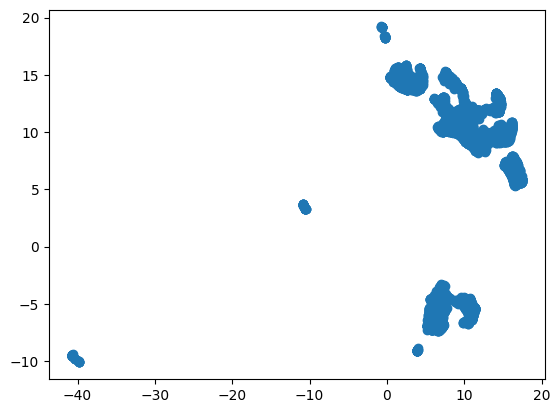

In [39]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=40,
  metric="precomputed",
  random_state=semillas[0],
).fit_transform(md)

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

Agreguemos la dimensión de la probabilidad de salida, para ver donde cree el modelo que se encuentran los **bajas**.

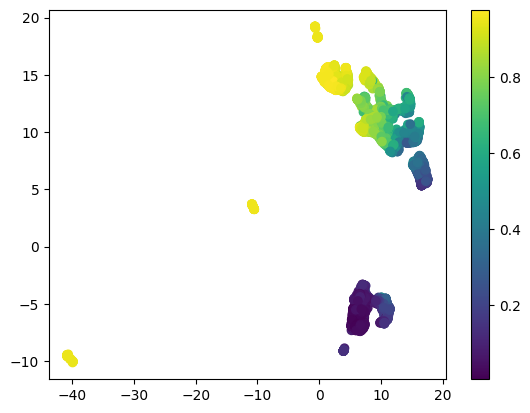

In [40]:
class_index = np.where(model_rf_1.classes_ == 1)[0]
prob_baja = model_rf_1.predict_proba(Xtrain_rf_imp)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

Vamos a partir de este embedding para segmentar a los clientes. Puede utilizar cualquier técnica, los datos ya son simples para cualquier algoritmo. Utilizaremos uno bastante estandar

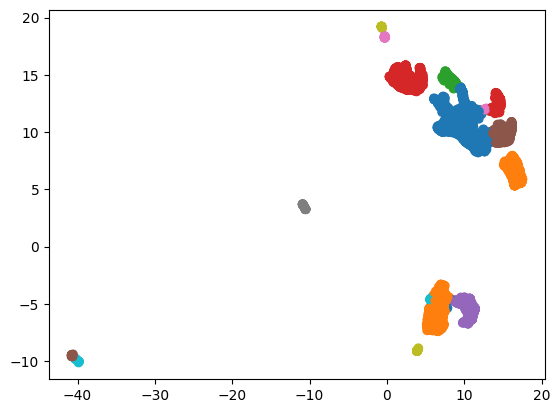

In [41]:
hdb = DBSCAN(eps=0.3)
y = hdb.fit(embedding_rf)

plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab10')
# plt.tight_layout()
plt.show()

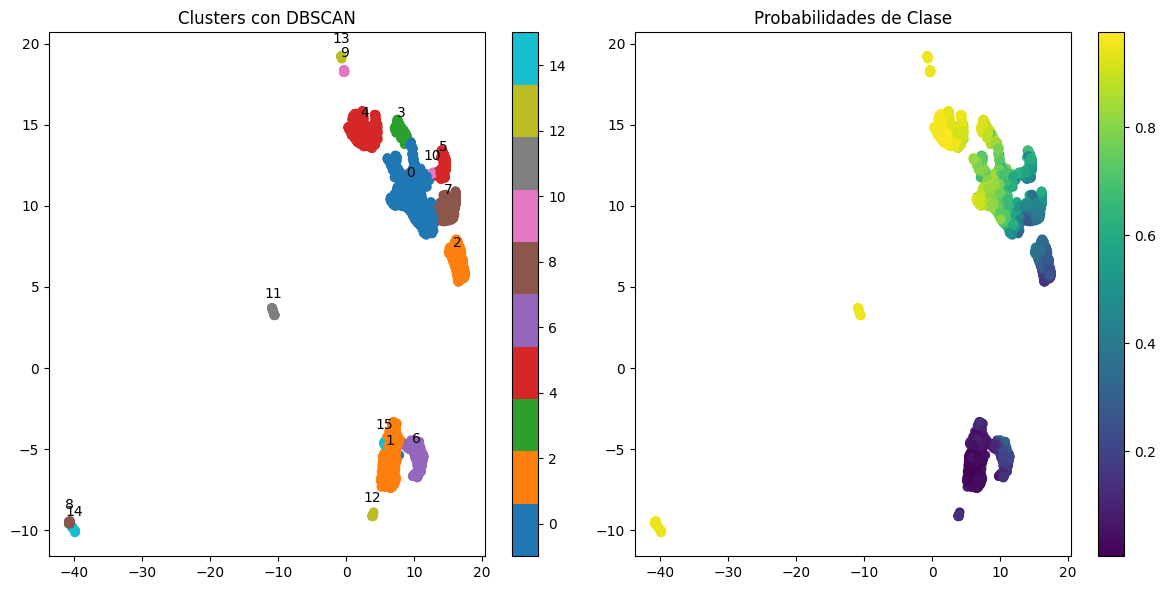

In [42]:
# Ajustamos el modelo DBSCAN (como en tu código)
hdb = DBSCAN(eps=0.3)
y = hdb.fit(embedding_rf)

# Creamos la figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Primer gráfico: clusters con anotaciones
scatter1 = ax1.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab10')

# Anotamos el número de clústeres en el centro de cada grupo
unique_labels = set(y.labels_)
for label in unique_labels:
    if label == -1:  # Ignoramos el ruido (outliers)
        continue
    mask = (y.labels_ == label)
    cluster_center = embedding_rf[mask].mean(axis=0)
    ax1.annotate(f'{label}', cluster_center, textcoords="offset points", xytext=(0, 10), ha='center')

ax1.set_title('Clusters con DBSCAN')
fig.colorbar(scatter1, ax=ax1)

# Segundo gráfico: probabilidades de clase
class_index = np.where(model_rf_1.classes_ == 1)[0]
prob_baja = model_rf_1.predict_proba(Xtrain_rf_imp)[:, class_index]

scatter2 = ax2.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=prob_baja)
ax2.set_title('Probabilidades de Clase')
fig.colorbar(scatter2, ax=ax2)

# Ajustamos el layout de toda la figura
plt.tight_layout()
plt.show()


Veamos cuantos cluster detecto y cuantos clientes tiene cada uno

In [32]:
pd.Series(y.labels_).value_counts()

 0     1379
 1      827
 3      546
 2      418
 5      299
 6      291
 4      191
 7       78
 11      35
 10      31
 8       20
 12      15
 9       14
-1       10
 14       9
 13       8
Name: count, dtype: int64

Los que tienen -1, son considerados outliers.

Por último necesitamos alguna forma de saber que hace a cada cluster distinto del otro. Para esto utilizaremos modelos (**rf**) que buscan separar los cluster uno a uno del resto de los datos.

Por cada modelo, miraremos cuales son las variables más importantes que separan los datos para luego caracterizarlos:

Manos a la obra:

In [33]:
df_embedding = pd.DataFrame(embedding_rf, columns=['embedding_1', 'embedding_2'])
df_embedding['cluster'] = y.labels_

clusters = df_embedding['cluster'].unique()

important_features_by_cluster = {}

for cluster in clusters:
  y_binary = (df_embedding['cluster'] == cluster).astype(int)

  model = RandomForestClassifier(random_state=17)
  model.fit(Xtrain_rf_imp, y_binary)

  importances = model.feature_importances_
  feature_names = Xtrain_rf.columns

  indices = np.argsort(importances)[::-1]
  important_features_by_cluster[cluster] = [feature_names[i] for i in indices]

Y exploramos cuales son las variables importantes por cada cluster

In [34]:
for cluster, features in important_features_by_cluster.items():
  print(f"Cluster {cluster} vs. Resto:")
  for feature in features[:12]:
    print(f"  - {feature}")


Cluster 0 vs. Resto:
  - mtarjetas_consumo
  - percent_rank_ctrx_quarter
  - ctrx_quarter
  - ctarjeta_visa_transacciones
  - mcaja_ahorro
  - percent_rank_mcaja_ahorro
  - m_payroll_total
  - avg_3_mcaja_ahorro
  - avg_3_ctrx_quarter
  - lag_1_ctrx_quarter
  - percent_rank_mpayroll
  - mpayroll
Cluster 1 vs. Resto:
  - m_payroll_total
  - percent_rank_mpayroll
  - mpayroll
  - mtarjetas_consumo
  - m_cpayroll_total
  - cpayroll_trx
  - ctarjeta_visa_transacciones
  - avg_3_cpayroll_trx
  - lag_1_mpayroll
  - ctrx_quarter
  - percent_rank_ctrx_quarter
  - percent_rank_cpayroll_trx
Cluster 2 vs. Resto:
  - ctrx_quarter
  - percent_rank_ctrx_quarter
  - mtarjetas_consumo
  - percent_rank_mpayroll
  - m_payroll_total
  - ctarjeta_visa_transacciones
  - mpayroll
  - lag_1_ctrx_quarter
  - avg_3_ctrx_quarter
  - lag_2_ctrx_quarter
  - cpayroll_trx
  - percent_rank_cpayroll_trx
Cluster 3 vs. Resto:
  - percent_rank_ctrx_quarter
  - avg_3_ctrx_quarter
  - ctrx_quarter
  - mcaja_ahorro
  - per

Luego resta, analizar los estadísticos de los datos de cada cluster para las variables importantes, comparar sus distribuciones con histogramas, boxplots, pivot tables, etc.


Junto con el diccionaro de datos, de sentido a lo que ve a través del análisis multivariado de datos.

Obviamente, esto es apenas mas que una semilla. Agregue las variables históricas, juegue con los **rf** y genere una segmentación pro, que encante a Miranda
